In [72]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
import numpy as np

EXTRACTED_DATA_PATH = "../../data/extracted"
OUTPUT_DATA_DIR = "../../data/processed"

df_nsl = pd.read_csv(f"{EXTRACTED_DATA_PATH}/fisa_astr_data.csv").set_index("year")
df_misc = pd.read_csv(f"{EXTRACTED_DATA_PATH}/FISA_non_nsl_selected_data.csv").set_index("year")

#
# Plotting
#
#plt.rc("axes", facecolor="#E6E6E6", axisbelow=True)
plt.rc("axes", axisbelow=True)

plt.rcParams["font.size"] = 20
plt.rcParams["mathtext.default"] = "regular"
plt.rcParams["figure.figsize"] = (20,7)

colors_wong = [
    "#000000", "#e69f00", "#56b4e9", "#009e73",
    "#f0e442", "#0072b2", "#d55e00", "#cc79a7"
]

![](/data/processed/nsl_requests.png)

<Figure size 2000x700 with 0 Axes>

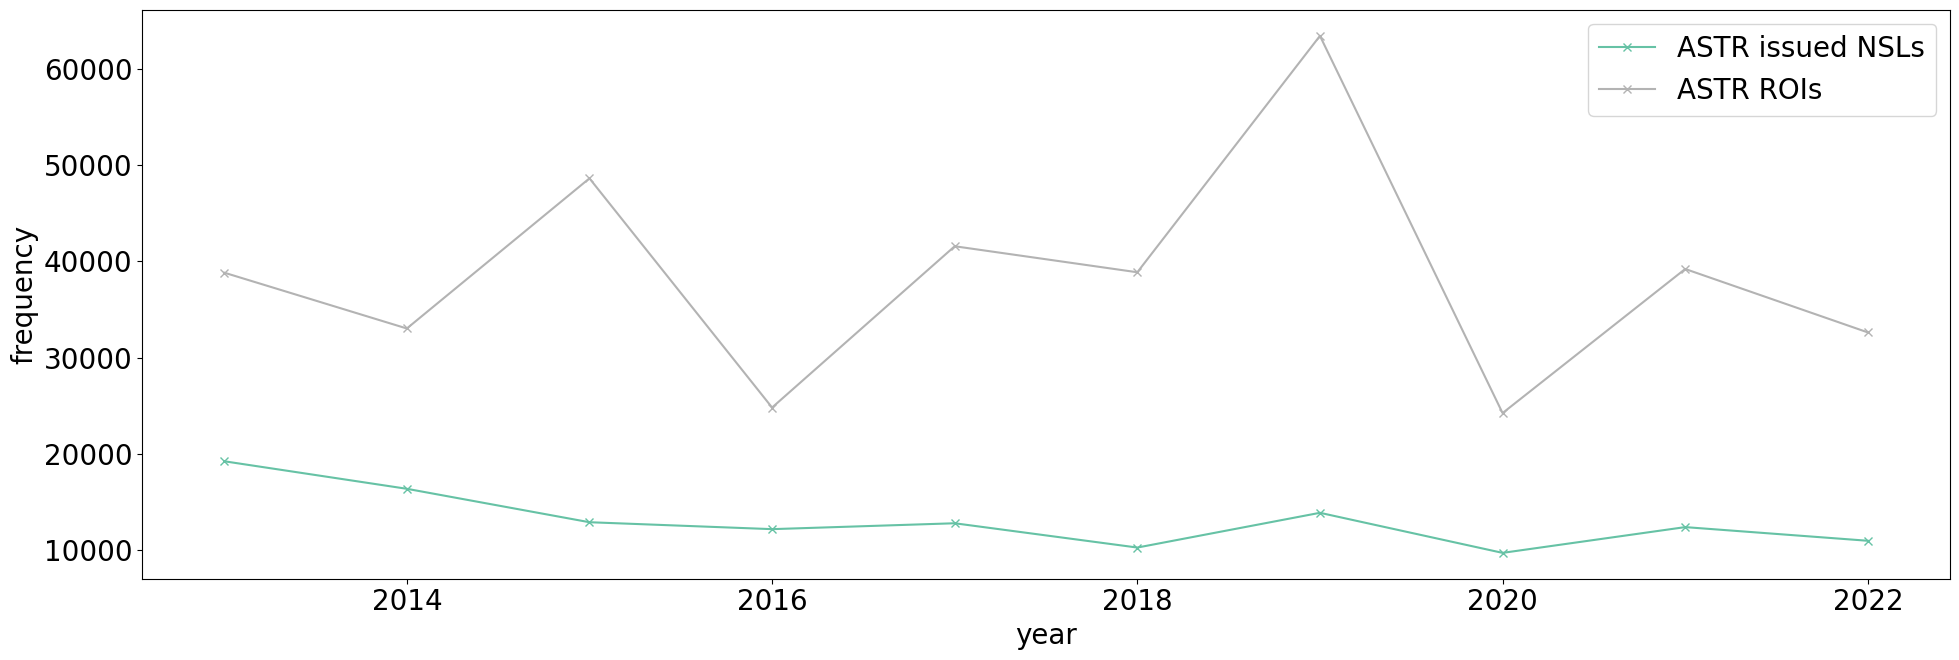

In [73]:
### plot the number of applications for NSLs and total number of ROIs as reported by ASTR

plt.rcParams["figure.figsize"] = (20,7)
plt.figure()
df_nsl[["ASTR issued NSLs", "ASTR ROIs"]].plot(marker="x", colormap="Set2")

plt.xlabel("year")
plt.ylabel("frequency")
plt.legend()
plt.tight_layout()
plt.savefig(f"{OUTPUT_DATA_DIR}/number_of_nsl_applications.pdf")
plt.savefig(f"{OUTPUT_DATA_DIR}/number_of_nsl_applications.png")

<Figure size 1400x800 with 0 Axes>

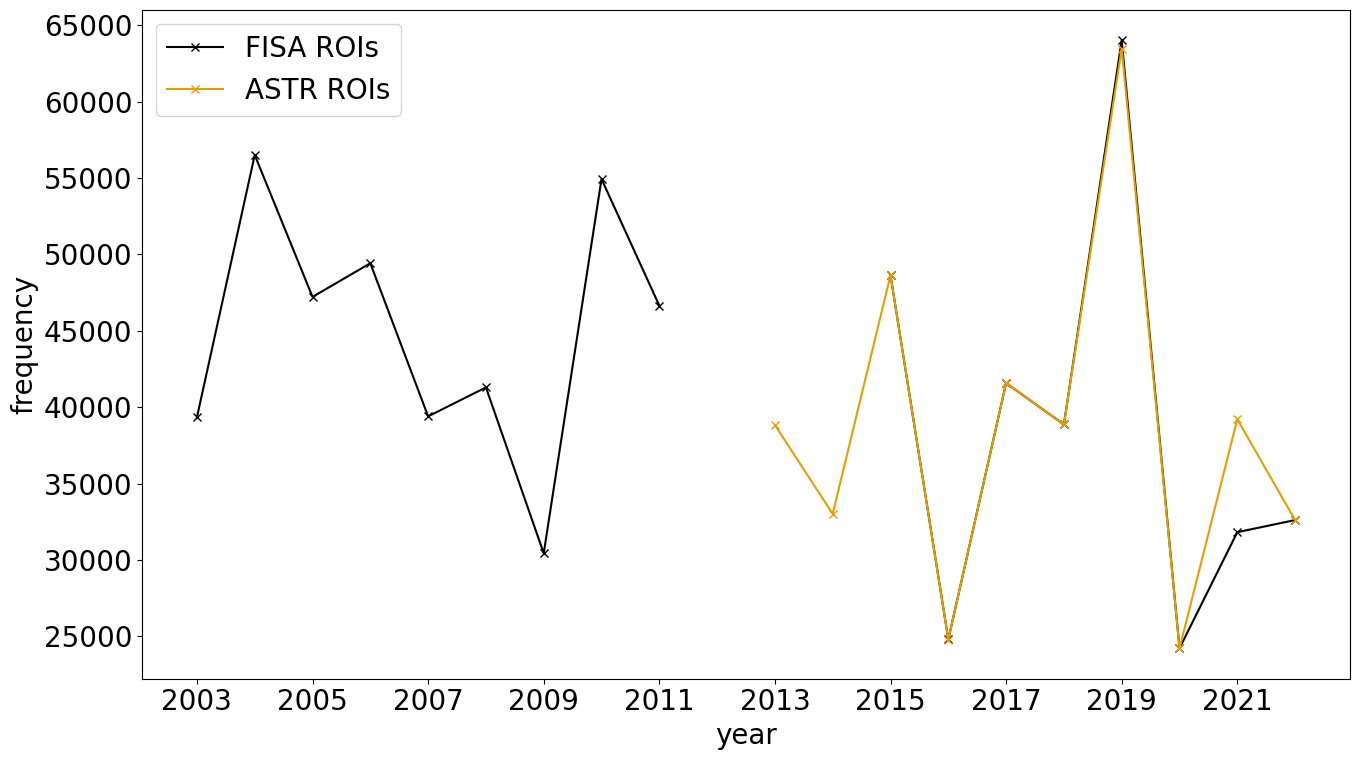

In [74]:
### plot the number of applications for NSLs and total number of ROIs as reported by ASTR

plt.rcParams["figure.figsize"] = (14,8)
plt.figure()
df_rois_totals = df_nsl[["total ROIs", "ASTR ROIs"]].rename(columns={"total ROIs": "FISA ROIs"})
df_rois_totals.plot(marker="x", color=colors_wong)

df_rois_index = df_rois_totals.dropna(how='all').index
xticks = list(range(df_rois_index.min(), df_rois_index.max(), 2))
plt.xticks(xticks)
plt.xlabel("year")
plt.ylabel("frequency")
plt.legend()
plt.tight_layout()
plt.savefig(f"{OUTPUT_DATA_DIR}/roi_totals.pdf")
plt.savefig(f"{OUTPUT_DATA_DIR}/roi_totals.png")

<Figure size 2000x700 with 0 Axes>

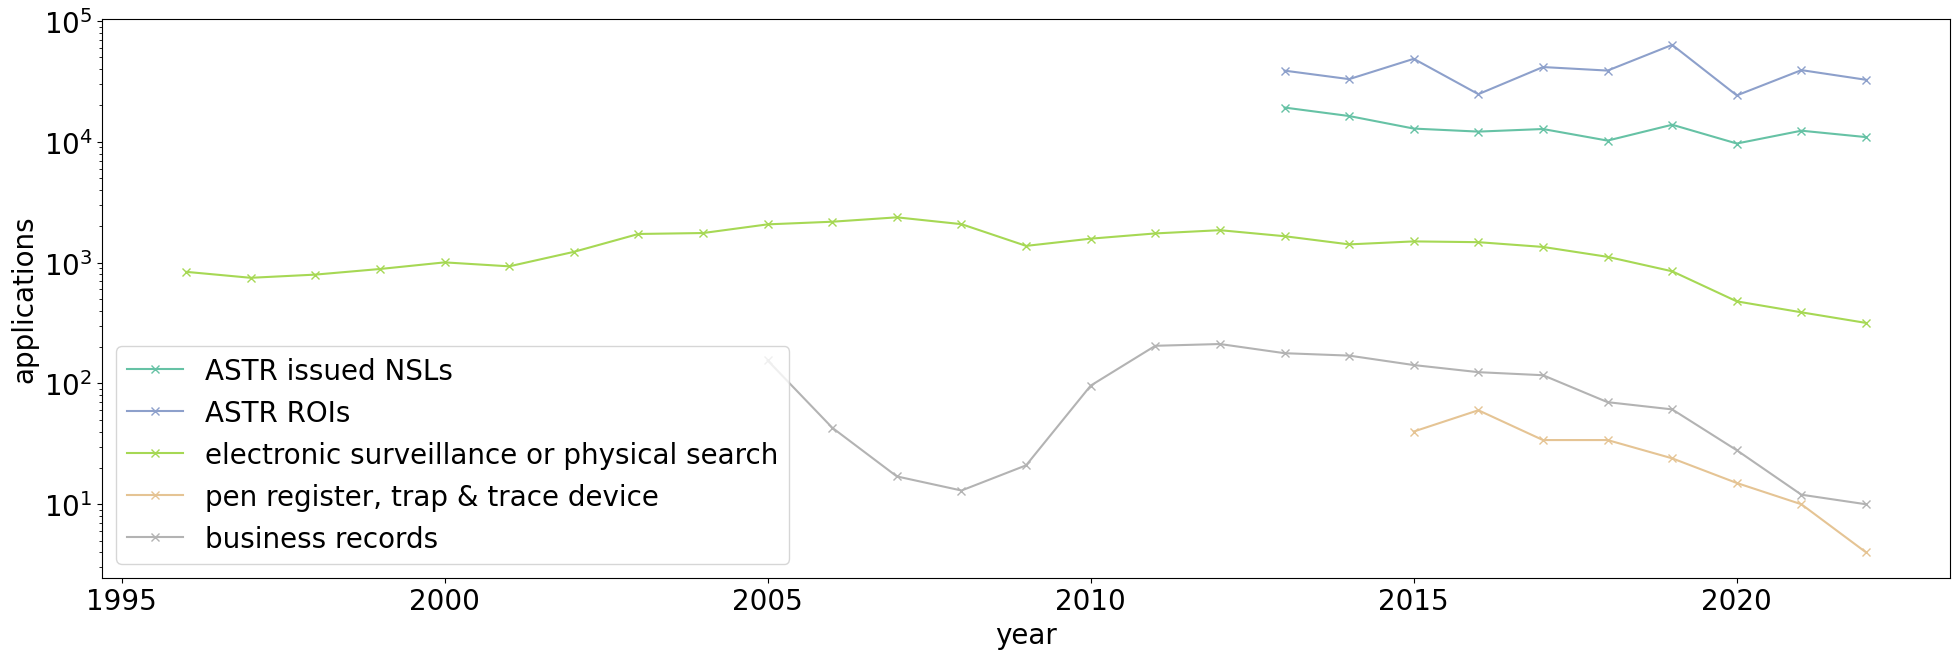

In [75]:
### plot the number of applications for NSLs, 1805 (electronic surveillance), 1824 (physical search), 1842 (pen register, trap & trace device), and 1861 (business records)

df_nr_apps = pd.concat([df_nsl[["ASTR issued NSLs", "ASTR ROIs"]], df_misc[["electronic surveillance or physical search", "pen register, trap & trace device", "business records"]]], axis=1)

plt.rcParams["figure.figsize"] = (20,7)
plt.figure()
df_nr_apps.plot(marker="x", colormap="Set2")

plt.yscale("log")
plt.xlabel("year")
plt.ylabel("applications")
plt.legend()
plt.tight_layout()
plt.savefig(f"{OUTPUT_DATA_DIR}/number_of_all_applications.pdf")
plt.savefig(f"{OUTPUT_DATA_DIR}/number_of_all_applications.png")

<Figure size 2000x700 with 0 Axes>

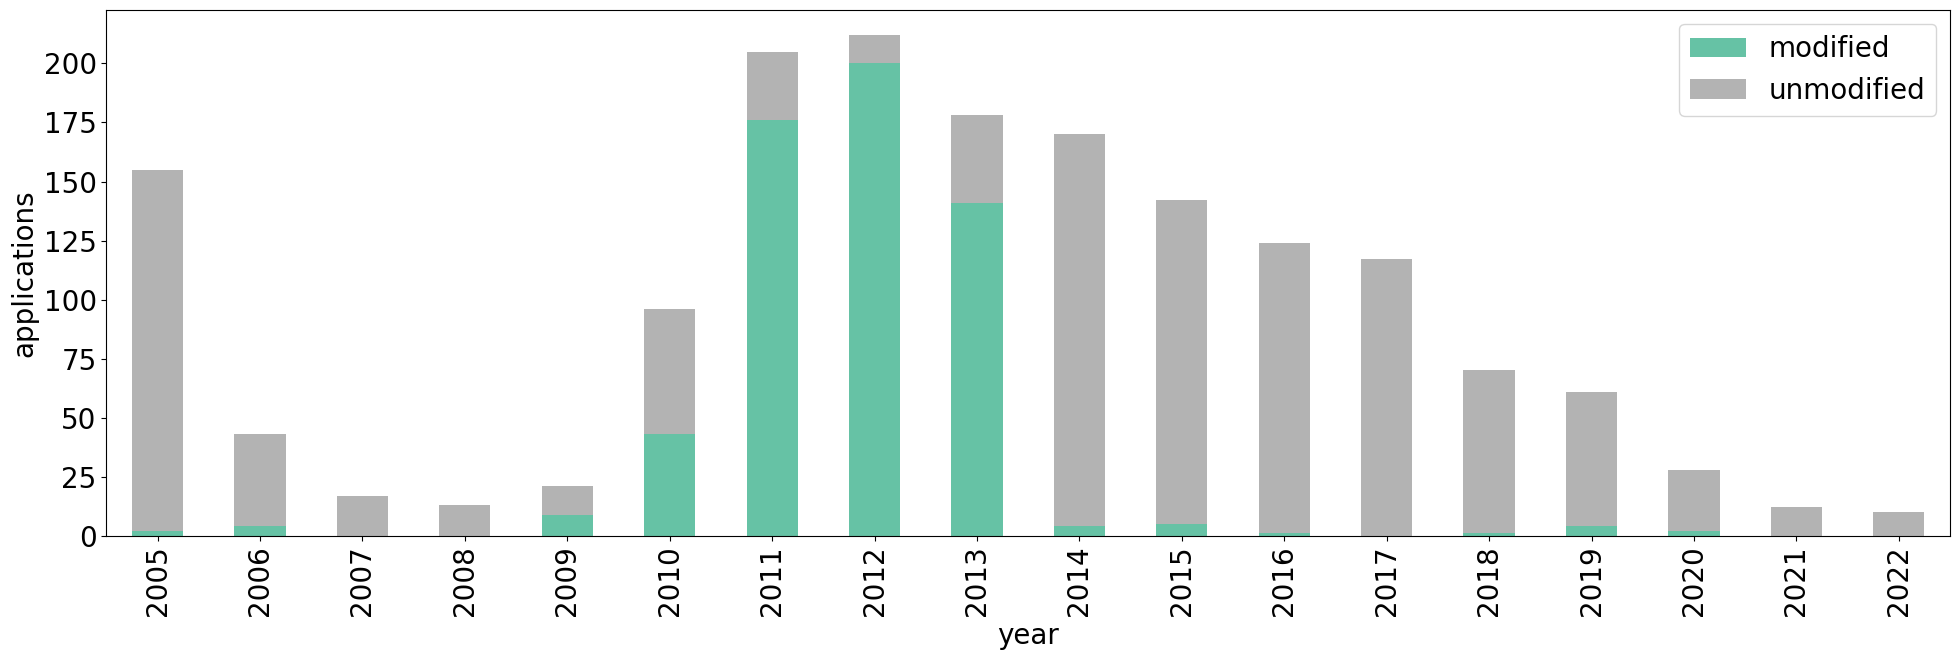

In [76]:
### business records plot

df_business_records = df_misc[["modified applications for business records"]].rename(columns={"modified applications for business records": "modified"})
df_business_records["unmodified"] = df_misc["business records"]-df_misc["modified applications for business records"]

plt.figure()
df_business_records[df_business_records.index >= 2005].plot.bar(colormap="Set2", stacked=True)

plt.xlabel("year")
plt.ylabel("applications")

plt.legend()
plt.tight_layout()
plt.savefig(f"{OUTPUT_DATA_DIR}/business_records.pdf") 
plt.savefig(f"{OUTPUT_DATA_DIR}/business_records.png") 

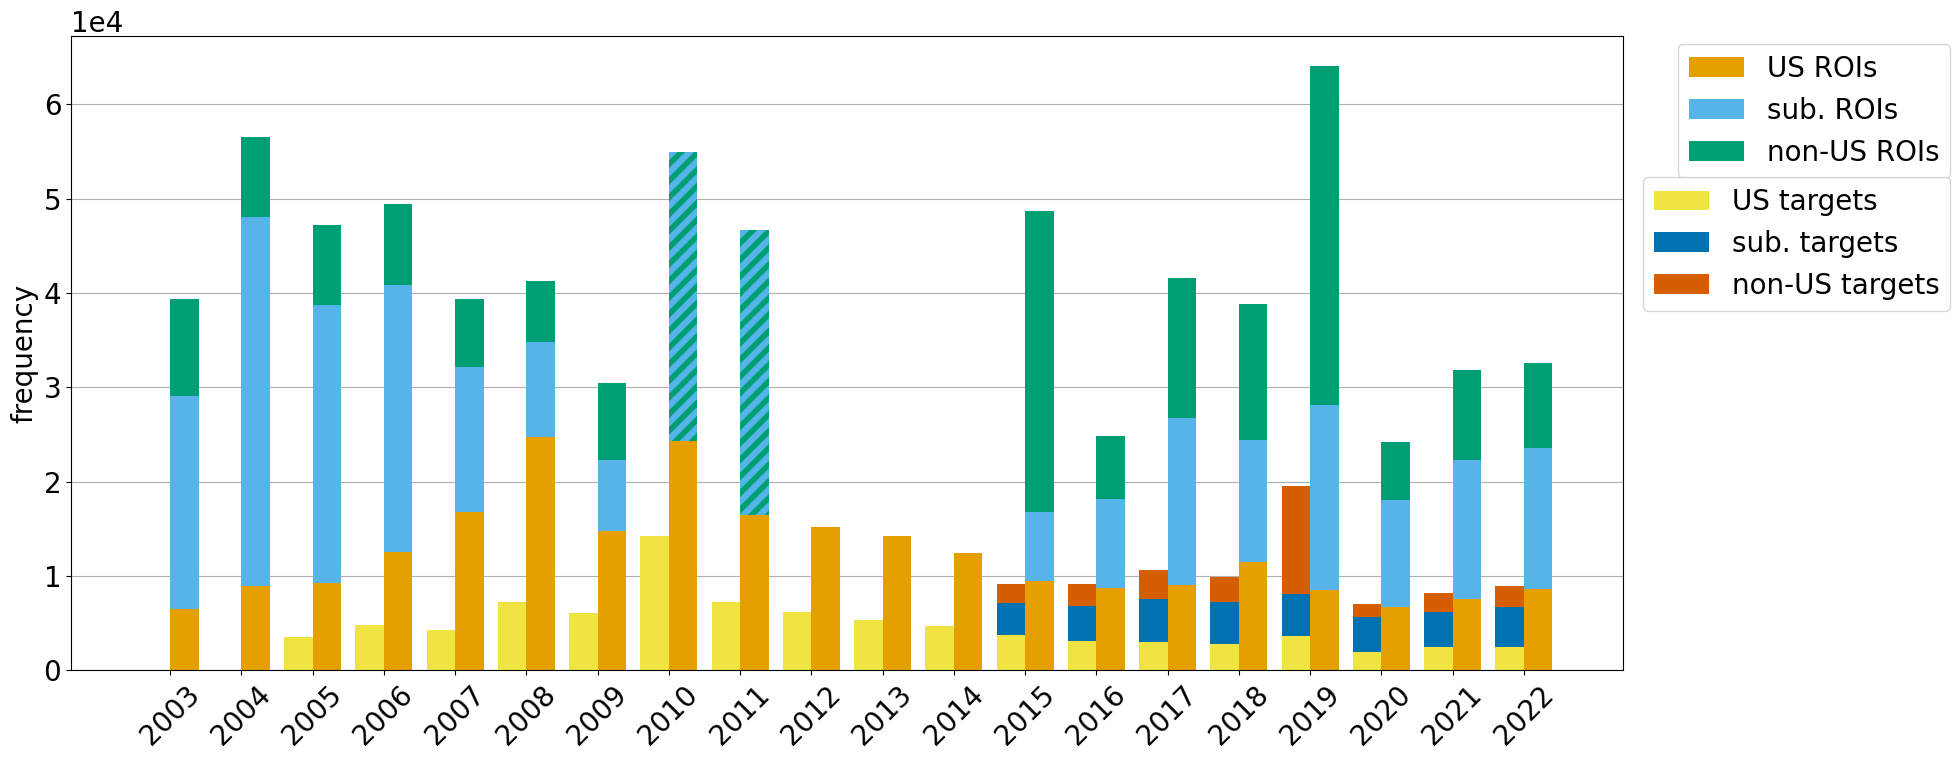

In [77]:
### stacked NSL requests bar plot

plt.rcParams["figure.figsize"] = (20,8)

# Use shorter column names (because they end up in the plot legend)
# Names starting with an underline (_) are excluded from the plot legend.
df_nsl.rename(columns={
    "subscriber targets": "sub. targets",
    "subscriber ROIs": "sub. ROIs",
    "subscriber ROIs inferred (total ROIs - non-US ROIs - US ROIs)": "_sub. ROIs",
    "subscriber + non-US ROIs inferred (total - US ROIs)": "_sub. + non-US ROIs"
    }, inplace=True)

# Select ROI related columns
df_nsl_reqs = df_nsl[["US ROIs", "sub. ROIs", "non-US ROIs", "_sub. + non-US ROIs"]]
# Limit data to after 2003 (when NSL data is available)
df_nsl_reqs = df_nsl_reqs[df_nsl_reqs.index >= 2003]

# Remove subscriber ROI data with NAN entries in gap from 2010 to 2015
df_nsl_reqs["sub. ROIs"] = df_nsl_reqs["sub. ROIs"].where(df_nsl_reqs["sub. ROIs"].notnull(), df_nsl["_sub. ROIs"])

# Select NSL target related columns
df_nsl_targets = df_nsl[["US targets", "sub. targets", "non-US targets"]]
# Limit data to after 2003 (when NSL data is available)
df_nsl_targets = df_nsl_targets[df_nsl_targets.index >= 2003]

# Create a bar plot
fig, ax = plt.subplots()
plt.ticklabel_format(axis='both', style='sci', scilimits=(4,4))

# change hatch line width for stripped bar
mpl.rcParams['hatch.linewidth'] = 4.0

# Plot NSL ROIs
df_nsl_reqs.plot.bar(stacked=True, width=0.4, position=0, ax=ax, color=colors_wong[1:4])

# Plot combined subscriber and non-US ROI data for years where no other data is available
df_nsl_reqs["_sub. + non-US ROIs"].plot.bar(width=0.4, position=0, ax=ax,
    facecolor=colors_wong[2], edgecolor=colors_wong[3], hatch=r'//', bottom=df_nsl_reqs["US ROIs"], linewidth=0.0)

# Plot NSL targets
df_nsl_targets.plot.bar(stacked=True, width=0.4, position=1, ax=ax, color=colors_wong[4:])

# Split legend into two halves, one for ROIs the other for NSL targets
lines, labels = ax.get_legend_handles_labels()
mid = len(lines)//2
roi_lines, roi_labels = lines[:mid], labels[:mid]
tar_lines, tar_labels = lines[mid:], labels[mid:]
roi_legend = plt.legend(roi_lines, roi_labels, loc="upper right", bbox_to_anchor=(1.22, 1.01))

plt.gca().add_artist(roi_legend)
plt.legend(tar_lines, tar_labels, loc="upper right", bbox_to_anchor=(1.22, 0.8))

plt.xlabel(None)
plt.ylabel("frequency")

plt.grid(axis="y")
plt.xticks(rotation=45)#, ha='right')
ax.autoscale()

plt.tight_layout()
# plt.subplots_adjust(left=0, bottom=0, right=1.1, top=1.2, wspace=0, hspace=0)
plt.savefig(f"{OUTPUT_DATA_DIR}/nsl_requests.pdf") 
plt.savefig(f"{OUTPUT_DATA_DIR}/nsl_requests.png") 

In [96]:
df_nsls_per_target = (df_nsl_reqs[df_nsl_reqs.index>=2015].sum(axis=1, numeric_only=True) / df_nsl_targets[df_nsl_targets.index>=2015].sum(axis=1, numeric_only=True))
print(df_nsls_per_target.mean(), df_nsls_per_target.std(), df_nsls_per_target.max())

3.7599948225033204 0.749887309346282 5.318390553247321


In [78]:
def make_kilo(value, _):
    value_k = str(int(value / 1000))
    if value_k != "0":
        value_k += "k"
    return value_k

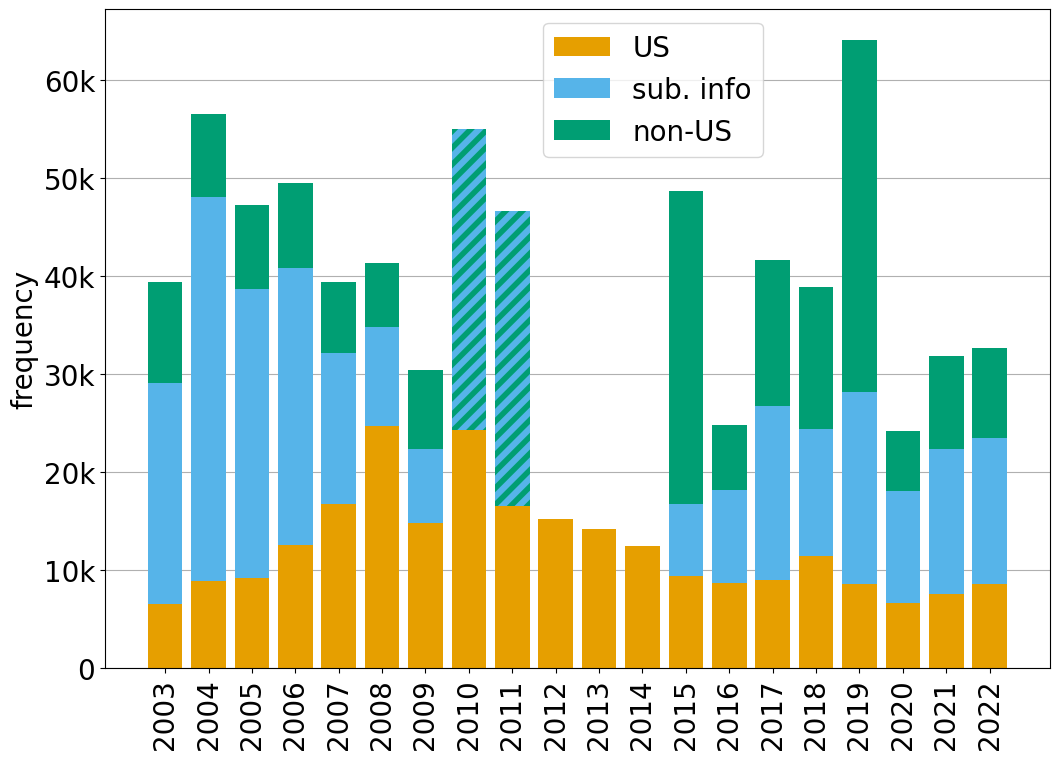

In [81]:
### stacked NSL requests bar plot; only requests for information

plt.rcParams["font.size"] = 20
plt.rcParams["figure.figsize"] = (11,8)

# Use shorter column names (because they end up in the plot legend)
# Names starting with an underline (_) are excluded from the plot legend.
df_nsl_rois = df_nsl.rename(columns={
    "sub. ROIs": "sub. info",
    "US ROIs": "US",
    "non-US ROIs": "non-US",
    "subscriber ROIs inferred (total ROIs - non-US ROIs - US ROIs)": "_sub. ROIs",
    "subscriber + non-US ROIs inferred (total - US ROIs)": "_sub. + non-US ROIs"
    })

# Select ROI related columns
df_nsl_reqs = df_nsl_rois[["US", "sub. info", "non-US", "_sub. + non-US ROIs"]]
# Limit data to after 2003 (when NSL data is available)
df_nsl_reqs = df_nsl_reqs[df_nsl_reqs.index >= 2003]

# Remove subscriber ROI data with NAN entries in gap from 2010 to 2015
df_nsl_reqs["sub. info"] = df_nsl_reqs["sub. info"].where(df_nsl_reqs["sub. info"].notnull(), df_nsl["_sub. ROIs"])

# Create a bar plot
fig, ax = plt.subplots()
# plt.ticklabel_format(axis='both', style='sci', scilimits=(4,4))

plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(make_kilo))

# change hatch line width for stripped bar
mpl.rcParams['hatch.linewidth'] = 4.0

# Plot NSL ROIs
df_nsl_reqs.plot.bar(stacked=True, width=0.8, ax=ax, color=colors_wong[1:4])

# Plot combined subscriber and non-US ROI data for years where no other data is available
df_nsl_reqs["_sub. + non-US ROIs"].plot.bar(width=0.8, ax=ax,
    facecolor=colors_wong[2], edgecolor=colors_wong[3], hatch=r'//', bottom=df_nsl_reqs["US"], linewidth=0.0)

plt.legend(loc="upper center", bbox_to_anchor=(0.33, 0.5, 0.5, 0.5))

plt.xlabel(None)
plt.ylabel("frequency")

plt.grid(axis="y")
plt.xticks(rotation=90, ha='center')
ax.autoscale()

plt.tight_layout()
# plt.subplots_adjust(left=0, bottom=0, right=1.1, top=1.2, wspace=0, hspace=0)
plt.savefig(f"{OUTPUT_DATA_DIR}/nsl_roi_requests.pdf") 
plt.savefig(f"{OUTPUT_DATA_DIR}/nsl_roi_requests.png") 

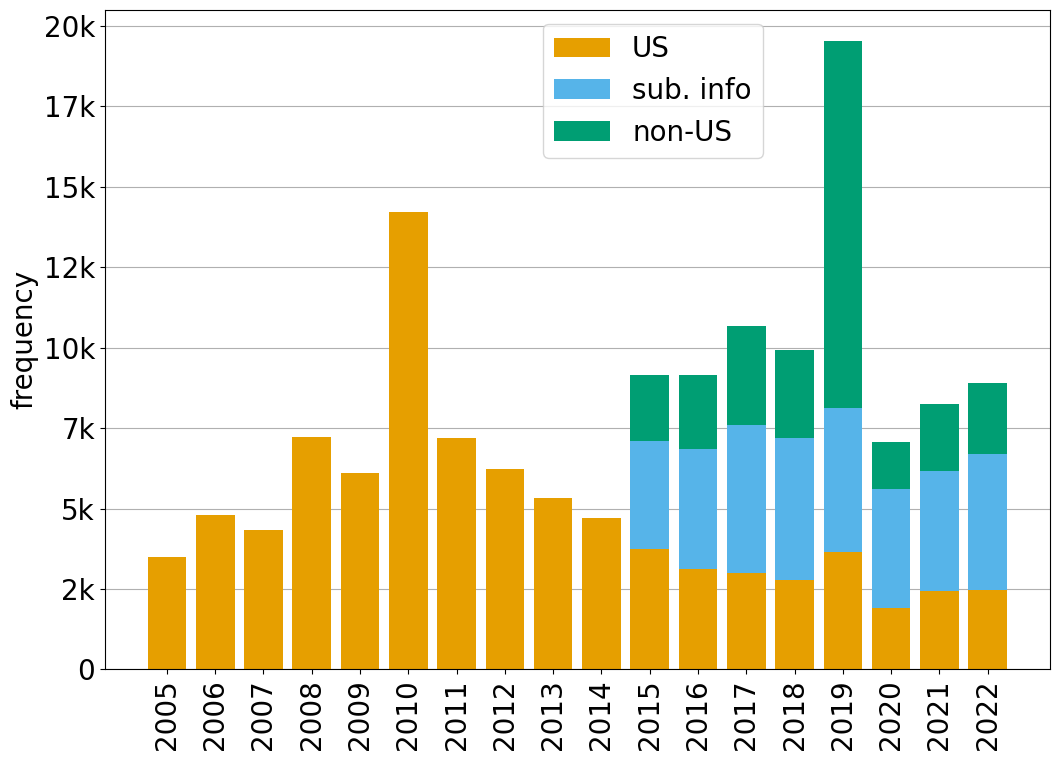

In [ ]:
### stacked NSL requests bar plot; only target information

plt.rcParams["figure.figsize"] = (11,8)

# Use shorter column names (because they end up in the plot legend)
# Names starting with an underline (_) are excluded from the plot legend.
df_nsl_targets = df_nsl.rename(columns={
    "sub. targets": "sub. info",
    "US targets": "US",
    "non-US targets": "non-US"
    })

# Select NSL target related columns
df_nsl_targets = df_nsl_targets[["US", "sub. info", "non-US"]]
# Limit data to after 2005 (when NSL data added information on targets)
df_nsl_targets = df_nsl_targets[df_nsl_targets.index >= 2005]

# Create a bar plot
fig, ax = plt.subplots()
# plt.ticklabel_format(axis='both', style='sci', scilimits=(4,4))
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(make_kilo))

# Plot NSL targets
df_nsl_targets.plot.bar(stacked=True, width=0.8, ax=ax, color=colors_wong[1:4])

plt.legend(loc="upper center", bbox_to_anchor=(0.33, 0.5, 0.5, 0.5))

plt.xlabel(None)
plt.ylabel("frequency")

plt.grid(axis="y")
plt.xticks(rotation=90, ha='center')
ax.autoscale()

plt.tight_layout()
plt.savefig(f"{OUTPUT_DATA_DIR}/nsl_targets.pdf") 
plt.savefig(f"{OUTPUT_DATA_DIR}/nsl_targets.png") 

[2003, 2005, 2007, 2009, 2011, 2013, 2015, 2017, 2019, 2021]


<Figure size 1500x800 with 0 Axes>

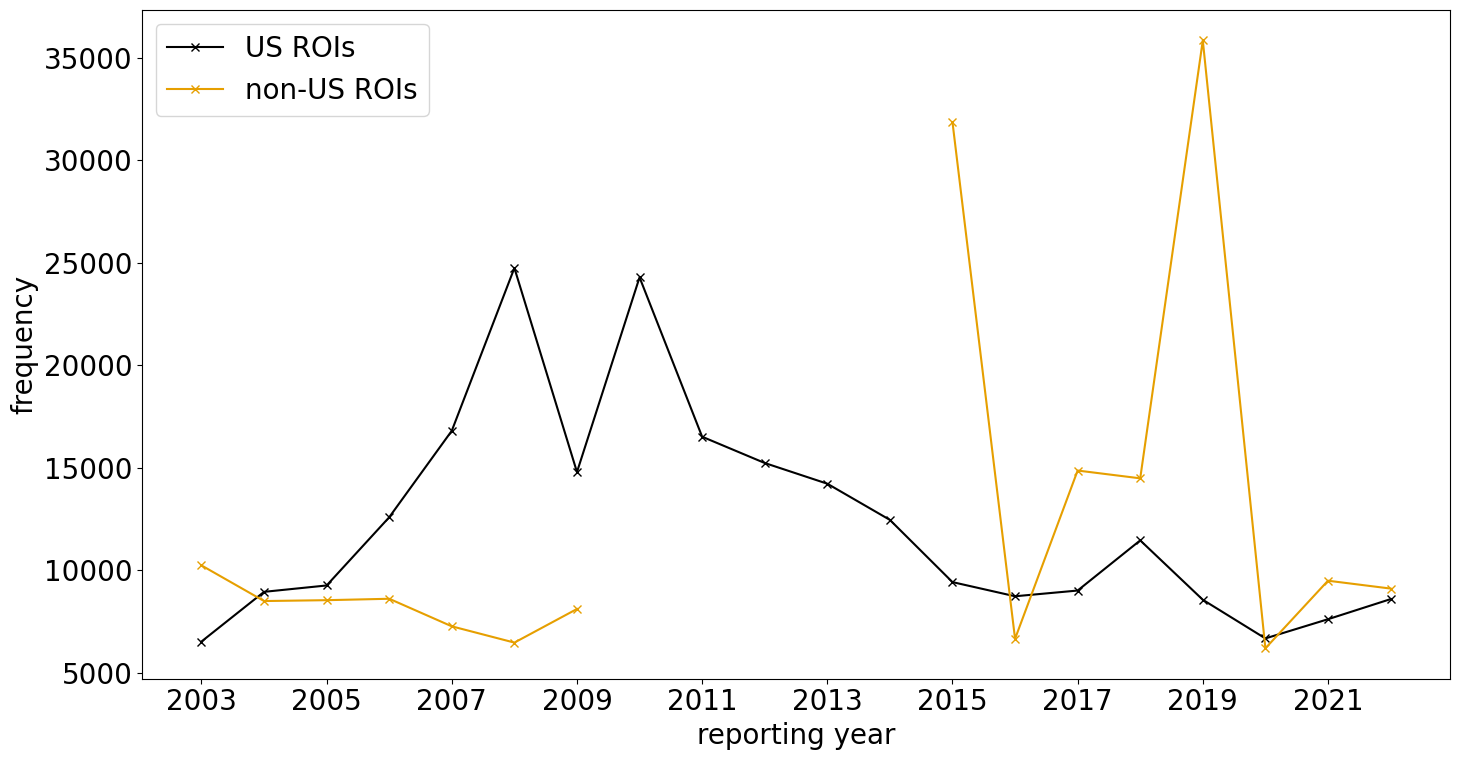

In [ ]:
### plot the number of applications for NSLs and total number of ROIs as reported by ASTR

plt.rcParams["font.size"] = 20
plt.rcParams["figure.figsize"] = (15,8)
plt.figure()

df_rois = df_nsl[["US ROIs", "non-US ROIs"]] #, "ASTR ROIs", "total ROIs"
df_rois.plot(marker="x", color=colors_wong)

df_rois_index = df_rois.dropna().index
xticks = list(range(df_rois_index.min(), df_rois_index.max(), 2))
print(xticks)
plt.xticks(xticks)
plt.xlabel("reporting year")
plt.ylabel("frequency")
plt.legend()
plt.tight_layout()
plt.savefig(f"{OUTPUT_DATA_DIR}/non-US_vs_US_ROIs.pdf")
plt.savefig(f"{OUTPUT_DATA_DIR}/non-US_vs_US_ROIs.png")